# Problem 2:

In [62]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Problem 2.1:

In [48]:
# Problem 2.1: Read and import the provided (.csv) dataset
file_path = '../IMUData.csv'

data = pd.read_csv(file_path)

# gyroscope data: meaning rotation around the x, y, and z axis
# accelerometer data: meaning acceleration along the x, y, and z axis
# magnetometer data: meaning magnetic field strength along the x, y, and z axis
data.head()

,time,gyroscope.X,gyroscope.Y,gyroscope.Z,accelerometer.X,accelerometer.Y,accelerometer.Z,magnetometer.X,magnetometer.Y,magnetometer.Z
0,0.000000,-0.9375,-1.250,0.875,0.019043,-0.052246,0.97803,0.20996,0.031250,-0.44873
1,0.003906,-0.9375,-1.250,0.875,0.019043,-0.052246,0.97803,0.20996,0.031250,-0.44873
2,0.007812,-0.9375,-1.875,0.250,0.019043,-0.067871,0.99756,0.20996,0.031250,-0.44873
3,0.011719,-1.3125,-2.000,0.125,0.026855,-0.032715,0.98975,0.21484,0.041016,-0.45361
4,0.015625,-1.7500,-2.125,0.000,0.003418,-0.032715,0.99365,0.21484,0.041016,-0.45361


### Problem 2.2

In [49]:
# Problem 2.2: Convert rotational rate to radians
def convert_rate_to_radians(gyroscope):
    return gyroscope * np.pi / 180

data[' gyroscope.X'] = convert_rate_to_radians(data[' gyroscope.X'])
data[' gyroscope.Y'] = convert_rate_to_radians(data[' gyroscope.Y'])
data[' gyroscope.Z'] = convert_rate_to_radians(data[' gyroscope.Z'])

# Problem 2.2: Normalize the magnitude of the accelerometer and magnetometer data, this is for dataframes
def df_normalize_magnitude(data):
    vectorx, vectory, vectorz = data
    magnitude = np.sqrt(vectorx**2 + vectory**2 + vectorz**2)
    # take care of the case where the magnitude is 0
    if magnitude == 0:
        return data
    return data/magnitude

data[[' accelerometer.X', ' accelerometer.Y', ' accelerometer.Z']] = data[[' accelerometer.X', ' accelerometer.Y', ' accelerometer.Z']].apply(normalize_magnitude, axis=1, result_type='broadcast')
data[[' magnetometer.X', ' magnetometer.Y', ' magnetometer.Z ']] = data[[' magnetometer.X', ' magnetometer.Y', ' magnetometer.Z ']].apply(normalize_magnitude, axis=1, result_type='broadcast')
data.head()

,time,gyroscope.X,gyroscope.Y,gyroscope.Z,accelerometer.X,accelerometer.Y,accelerometer.Z,magnetometer.X,magnetometer.Y,magnetometer.Z
0,0.000000,-0.016362,-0.021817,0.015272,0.019439,-0.053333,0.998388,0.422961,0.062953,-0.903959
1,0.003906,-0.016362,-0.021817,0.015272,0.019439,-0.053333,0.998388,0.422961,0.062953,-0.903959
2,0.007812,-0.016362,-0.032725,0.004363,0.019042,-0.067868,0.997513,0.422961,0.062953,-0.903959
3,0.011719,-0.022907,-0.034907,0.002182,0.027108,-0.033024,0.999087,0.426619,0.081448,-0.900757
4,0.015625,-0.030543,-0.037088,0.000000,0.003438,-0.032906,0.999453,0.426619,0.081448,-0.900757


####  Problem 2.3: 
#### This part we follow: An efficient orientation filter for inertial and inertial/magnetic sensor arrays 
#### by Sebastian O.H. Madgwick

In [50]:
# Problem 2.3a: Convert Euler angle readings (radians) to quaternion
# https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles

def euler_to_quaternion(roll_angle, pitch_angle, yaw_angle):
    w = np.cos(yaw_angle * 0.5) * np.cos(pitch_angle * 0.5) * np.cos(roll_angle * 0.5) + np.sin(yaw_angle * 0.5) * np.sin(pitch_angle * 0.5) * np.cos(roll_angle * 0.5)
    x = np.cos(yaw_angle * 0.5) * np.cos(pitch_angle * 0.5) * np.sin(roll_angle * 0.5) - np.sin(yaw_angle * 0.5) * np.sin(pitch_angle * 0.5) * np.cos(roll_angle * 0.5)
    y = np.sin(yaw_angle * 0.5) * np.cos(pitch_angle * 0.5) * np.sin(roll_angle * 0.5) + np.cos(yaw_angle * 0.5) * np.sin(pitch_angle * 0.5) * np.cos(roll_angle * 0.5)
    z = np.sin(yaw_angle * 0.5) * np.cos(pitch_angle * 0.5) * np.cos(roll_angle * 0.5) - np.cos(yaw_angle * 0.5) * np.sin(pitch_angle * 0.5) * np.sin(roll_angle * 0.5)
    result = np.array([w, x, y, z])
    return result

# Problem 2.3b: Convert quaternions to Euler angles (radians)
# https://math.stackexchange.com/questions/2975109/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr
def quaternion_to_euler(w,x,y,z):
	roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
	pitch = np.arcsin(2 * (w * y - z * x))
	yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
	result = np.array([roll, pitch, yaw]) 
	return result

# Problem 2.3c: Convert a quaternion to its conjugate (inverse rotation)
# https://math.stackexchange.com/questions/4281031/conjugate-of-unit-quaternion
def quaternion_to_conjugate(w,x,y,z):
	result = np.array([w, -x, -y, -z])
	return result

# Problem 2.3d: Calculate the quaternion product of quaternion a and b
# https://automaticaddison.com/how-to-multiply-two-quaternions-together-using-python/
def calculate_quaternion_product(a,b):
    a1, a2, a3, a4 = a
    b1, b2, b3, b4 = b
    w = a1 * b1 - a2 * b2 - a3 * b3 - a4 * b4
    x = a1 * b2 + a2 * b1 + a3 * b4 - a4 * b3
    y = a1 * b3 - a2 * b4 + a3 * b1 + a4 * b2
    z = a1 * b4 + a2 * b3 - a3 * b2 + a4 * b1
    result = np.array([w, x, y, z])
    return result

### Problem 3.1:

In [198]:
# Problem 3.1: Implement the simple dead reckoning without the accelerometer (gravity-based tile correction): 
# as mentioned in the Q&A: first part is without the accelerometer, second part is with the accelerometer
# Follow by "Head Tracking for the Oculus Rift" and the question hints

def simple_dead_reckoning_without_accelerometer(df_data, inital_position, time_step, inital_velocity, gravity):
    
    # Initialize the position and velocity, we assume they are 0
    new_position = inital_position.copy()
    new_velocity = inital_velocity
    
    # Initialize the orientation quaternion, follow by the question setting.
    orientation_quaternion = np.array([1, 0, 0, 0])
    
    # store the position, pitch, roll, yaw
    positions = []
    pitches = []
    rolls = []
    yaws = []
    
    for index, row in df_data.iterrows():
        
        # gyroscope readings -> radians/sec
        gyroscope_x = row[' gyroscope.X']
        gyroscope_y = row[' gyroscope.Y']
        gyroscope_z = row[' gyroscope.Z']

        # convert the gyroscope readings to radians -> radians/sec * sec = radians
        angle = np.array([gyroscope_x, gyroscope_y, gyroscope_z]) * time_step

        # convert the angle to a quaternion
        rotation_quaternion = euler_to_quaternion(angle[0], angle[1], angle[2])

        # update the orientation quaternion by multiplying the current orientation quaternion by the rotation quaternion
        orientation_quaternion = calculate_quaternion_product(orientation_quaternion, rotation_quaternion)

        # convert the orientation quaternion to euler angles
        new_euler_angles = quaternion_to_euler(orientation_quaternion[0], orientation_quaternion[1], orientation_quaternion[2], orientation_quaternion[3])

        # gravity-based tile correction (without accelerometer) -> v = v + g * dt
        new_velocity += gravity * time_step

        # re-evaluate that position based on an estimated speed over the elapsed time -> x = x + v * dt
        new_position += new_velocity * time_step
        
        # store the position, pitch, roll, yaw
        positions.append(new_position.copy())
        
        pitch = new_euler_angles[1]
        roll = new_euler_angles[0]
        yaw = new_euler_angles[2]
        pitches.append(pitch)
        rolls.append(roll)
        yaws.append(yaw)
    return positions, pitches, rolls, yaws

position_sd, pitch, roll, yaw = simple_dead_reckoning_without_accelerometer(data, np.array([0.0,0.0,0.0]), 1/256, np.array([0.0,0.0,0.0]), np.array([0.0,0.0,-9.8]))


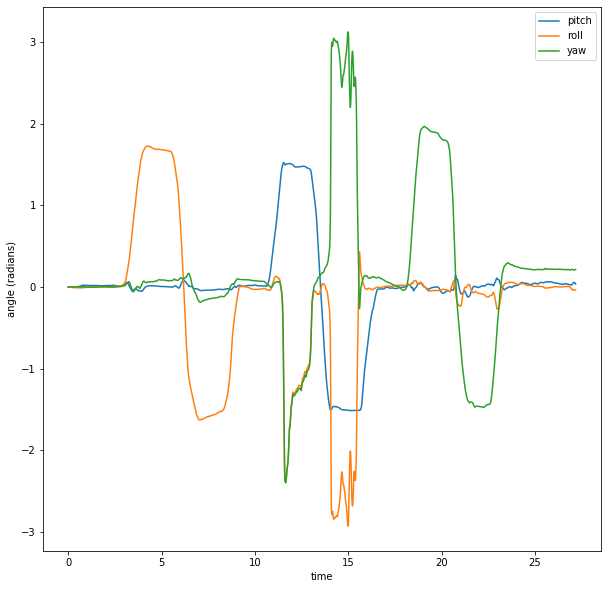

In [206]:
time = data['time'].values
# plot pitch, roll, yaw
plt.figure(figsize=(10,10))
plt.plot(time, pitch, label='pitch')
plt.plot(time, roll, label='roll')
plt.plot(time, yaw, label='yaw')
plt.xlabel('time')
plt.ylabel('angle (radians)')
plt.legend()
plt.show()

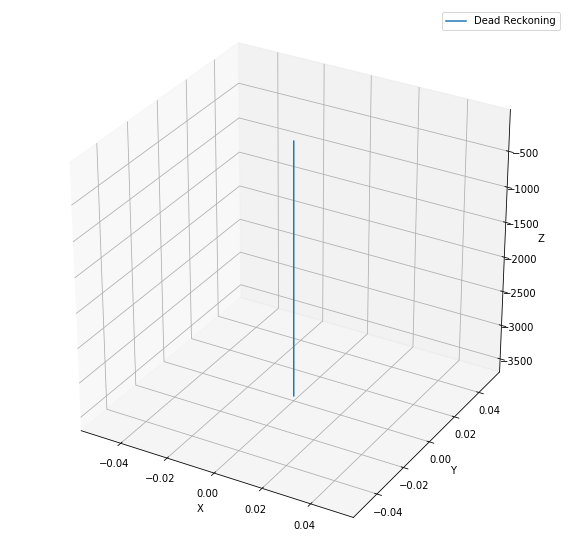

In [64]:
# plot the path of the dead reckoning
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot([x[0] for x in position_sd], [x[1] for x in position_sd], [x[2] for x in position_sd], label='Dead Reckoning')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [207]:
# Problem 3.2: Implement the simple dead reckoning with the accelerometer (gravity-based tile correction)

# normalize the magnitude of the vectors, different from the one in the previous function that take data frame as input
def normalize_magnitude(vectorx, vectory, vectorz):
	magnitude = np.sqrt(vectorx**2 + vectory**2 + vectorz**2)
	# take care of the case where the magnitude is 0
	if magnitude == 0:
		return vectorx, vectory, vectorz # return the original vector
	return vectorx/magnitude, vectory/magnitude, vectorz/magnitude

# calculate the global frame acceleration
# Follow by "Head Tracking for the Oculus Rift" a' = q^-1 * a * q
def accelaration_to_global(accelaration_x, accelaration_y, accelaration_z,orientation_quaternion):
    
    # get the acceleration quaternion
	accelaration_quaternion = np.array([0, accelaration_x, accelaration_y, accelaration_z])
    # first calculate: a * q
	accelaration_quaternion = calculate_quaternion_product(accelaration_quaternion, orientation_quaternion)
	# then calculate q^-1
	conjugate_orientation_quaternion = quaternion_to_conjugate(orientation_quaternion[0], orientation_quaternion[1], orientation_quaternion[2], orientation_quaternion[3])
	# finally calculate: q^-1 * (a * q)
	acceleration_global_frame = calculate_quaternion_product(accelaration_quaternion, conjugate_orientation_quaternion)
	return acceleration_global_frame

# calculate the tilt axis
# follow by "Head Tracking for the Oculus Rift" 
def calcualte_tilt_axis(acceleration_global_frame):
    # we first project the acceleration to the x-z plane: (a_x, 0, a_z), remember the acceleration_global_frame is in quaternion form (w,x,y,z)
	projected_acceleration = np.array([acceleration_global_frame[1],0, acceleration_global_frame[3]])
	# then we calculate the tilt axis: (a_z, 0, -a_x)
	tilt_axis = np.array([projected_acceleration[2], 0, -projected_acceleration[0]])
	# normalize the magnitude of the tilt axis
	tilt_axis = normalize_magnitude(tilt_axis[0], tilt_axis[1], tilt_axis[2])
	return tilt_axis

# helper function: calculate the tilt angle between two vectors
def angle_between_vectors(vector1, vector2):
    cosin_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    angle = np.arccos(cosin_angle)
    return angle

# complementary_filter -> follow by this guideline: https://drive.google.com/file/d/0B9rLLz1XQKmaLVJLSkRwMTU0b0E/view?resourcekey=0-oUq7ThstZRP9gGOzXQz9ZA
def complementary_filter(gyro_orientation, acceleration_orientation, alpha):
    return alpha * gyro_orientation + (1 - alpha) * acceleration_orientation

# Follow by "Head Tracking for the Oculus Rift"
def complete_dead_reckoning_with_accelerometer(df_data, time_step, alpha):
	orientation_quaternion = np.array([1, 0, 0, 0])
	pitches = []
	rolls = []
	yaws = []
	for index, row in df_data.iterrows():
        # Transform the gyroscope data to angular velocity - rad/s
		gyroscope_x = convert_rate_to_radians(row[' gyroscope.X'])
		gyroscope_y = convert_rate_to_radians(row[' gyroscope.Y'])
		gyroscope_z = convert_rate_to_radians(row[' gyroscope.Z'])
  
		angle = np.array([gyroscope_x, gyroscope_y, gyroscope_z]) * time_step
  
		rotation_quaternion = euler_to_quaternion(angle[0], angle[1], angle[2])

		orientation_quaternion = calculate_quaternion_product(orientation_quaternion, rotation_quaternion)

		accelaration_x, accelaration_y, accelaration_z = normalize_magnitude(row[' accelerometer.X'], row[' accelerometer.Y'], row[' accelerometer.Z'])

		accelaration_global_frame = accelaration_to_global(accelaration_x, accelaration_y, accelaration_z, orientation_quaternion)

		acceleration_vector = np.array([accelaration_global_frame[1], accelaration_global_frame[2], accelaration_global_frame[3]])
		# calculate the tilt axis
		tilt_axis = calcualte_tilt_axis(accelaration_global_frame)
		# calculate the tilt angle
		tilt_angle = angle_between_vectors(acceleration_vector, np.array([0, 0, 1]))
  
		acceleration_orientation = np.array([np.cos(tilt_angle/2), tilt_axis[0] * np.sin(tilt_angle/2), tilt_axis[1] * np.sin(tilt_angle/2), tilt_axis[2] * np.sin(tilt_angle/2)])
		
		# calcualte the fused orientation by using complementary filter
		fused_orientation = complementary_filter(rotation_quaternion, acceleration_orientation, alpha)
		orientation_quaternion = fused_orientation
		# convert the fused orientation to euler angles
		fused_orientation = quaternion_to_euler(fused_orientation[0], fused_orientation[1], fused_orientation[2], fused_orientation[3])
		pitch = fused_orientation[1]
		roll = fused_orientation[0]
		yaw = fused_orientation[2]
		pitches.append(pitch)
		rolls.append(roll)
		yaws.append(yaw)
  
	return pitches, rolls, yaws

In [273]:
pitch, roll, yaw = data[' gyroscope.X'] * 1/256, data[' gyroscope.Y'] * 1/256, data[' gyroscope.Z'] * 1/256
accelaration_x, accelaration_y, accelaration_z = data[' accelerometer.X'], data[' accelerometer.Y'], data[' accelerometer.Z']
pitches_003, rolls_003, yaws_003 = complete_dead_reckoning_with_accelerometer(data, 1/256, 0.03)

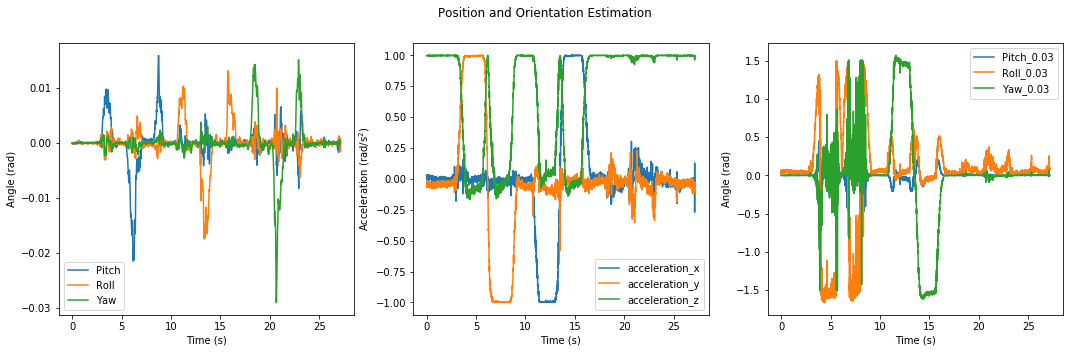

In [275]:

# display plots side by side
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.suptitle('Position and Orientation Estimation')
ax1.plot(time, pitch, label='Pitch')
ax1.plot(time, roll, label='Roll')
ax1.plot(time, yaw, label='Yaw')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)')
ax1.legend()

ax2.plot(time, accelaration_x, label='acceleration_x')
ax2.plot(time, accelaration_y, label='acceleration_y')
ax2.plot(time, accelaration_z, label='acceleration_z')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Acceleration (rad/s$^2$)')
ax2.legend()

ax3.plot(time, pitches_003, label='Pitch_0.03')
ax3.plot(time, rolls_003, label='Roll_0.03')
ax3.plot(time, yaws_003, label='Yaw_0.03')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Angle (rad)')
ax3.legend()

plt.show()


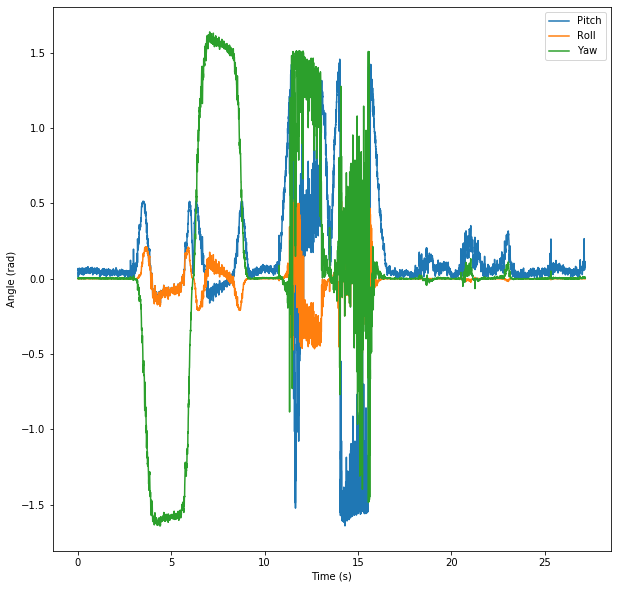

In [167]:
pitches_010, rolls_010, yaws_010 = complete_dead_reckoning_with_accelerometer(data, 1/256, 0.10)
time = data['time'].values
# plot the pitch, roll, yaw
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(time, pitches_010, label='Pitch')
ax.plot(time, rolls_010, label='Roll')
ax.plot(time, yaws_010, label='Yaw')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (rad)')
ax.legend()
plt.show()

In [313]:

# Problem 5.1: Implement the simple physic: let the object fall down with gravity acceleration and air resistance
def get_weight(mass, gravity):
	return mass * gravity

def get_drag_force(drag_coefficient, air_density, area, velocity):
    return 0.5 * drag_coefficient * air_density * area * velocity**2

# We assume that the object is falling down with a constant acceleration
# Weight is negative, drag force is positive
# Negative as the object is falling down
def get_total_force(weight, drag_force):
    return weight + drag_force

# acceleratin is going to be negative
def get_acceleration(total_force, mass):
    return total_force / mass

# We assume that the object is falling down with a constant acceleration
# Weight is negative, drag force is positive
# Negative as the object is falling down
def get_total_force(weight, drag_force):
    return weight + drag_force

# We assume that the object is falling down with a 0 initial velocity
def update_velocity(velocity, acceleration, dt):
    return velocity + acceleration * dt

def update_position(new_position, velocity, dt):
    return new_position + velocity * dt

# We assume that the object is falling down with a 0 initial velocity
inital_velocity = 0.0
inital_position = 0.0

# We assume the gravity is consent, and the direction is down:
inital_gravity = -9.81 # m/s^2
frame_rate = 256
time_stap = 1/frame_rate

# We assume the object is Quest2:
mass = 0.503 # kg

# We assume the Quest2 is a half sphere:
drag_coefficient = 0.42 # sphere

# We assume the air density is consent:
# And it will not change with the height:
# We assume the height of the inital headset is 5km:
# We use the air density of 5km, and data from: https://steamcommunity.com/sharedfiles/filedetails/?id=2942123847
air_density = 0.683 # kg/m^3 

# width and height of the headset:
length_object = 0.1915 # m
width_object = 0.102 # m
# We assume the area of the headset is the area of a rectangle:
area = length_object * width_object

positions = []
velocities = []
drag_forces = []
total_forces = []
accelarations = []
new_velocity = inital_velocity
new_position = inital_position
weight = get_weight(mass, inital_gravity)
area = length_object * width_object
for i in range(len(time)):
    drag_force = get_drag_force(drag_coefficient, air_density, area, new_velocity)
    total_force = get_total_force(weight, drag_force)
    acceleration = get_acceleration(total_force, mass)
    new_velocity = update_velocity(new_velocity, acceleration, time_stap)
    new_position = update_position(new_position, new_velocity, time_stap)
    drag_forces.append(drag_force)
    total_forces.append(total_force)
    accelarations.append(acceleration)
    positions.append(new_position)
    velocities.append(new_velocity)

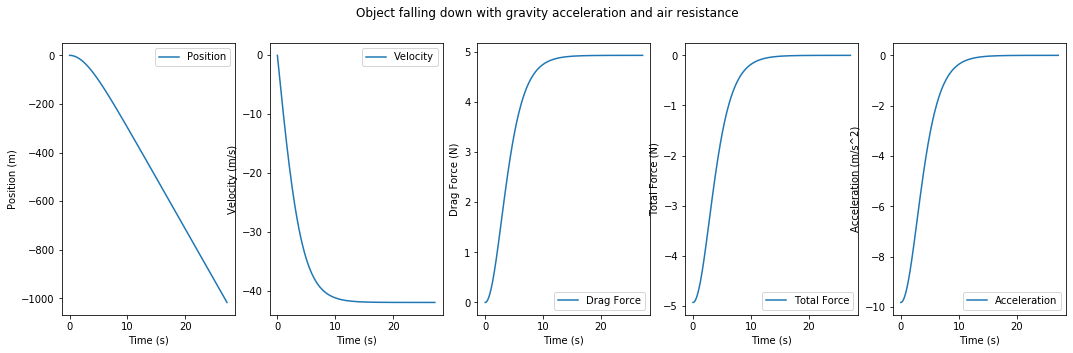

In [314]:
# plot the new position, velocity, drag force, total force and acceleration
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(18, 5))
fig.suptitle('Object falling down with gravity acceleration and air resistance')
ax1.plot(time, positions, label='Position')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (m)')
ax1.legend()

ax2.plot(time, velocities, label='Velocity')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (m/s)')
ax2.legend()

ax3.plot(time, drag_forces, label='Drag Force')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Drag Force (N)')
ax3.legend()

ax4.plot(time, total_forces, label='Total Force')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Total Force (N)')
ax4.legend()

ax5.plot(time, accelarations, label='Acceleration')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Acceleration (m/s^2)')
ax5.legend()

plt.show()


## Convert frame images to a video with FPS 256


In [315]:
import cv2
import os

# Set the directory containing the frame images
image_folder = './frames_withoutPhysics/'
images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]

In [316]:
images.sort(key=lambda x: int(x.split('.')[0].split('_')[1]))

In [317]:
# Set the video output path and properties
video_name = './output_video_Q5.mp4'
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# You can set the desired video codec, frames per second (fps), and output size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 256
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Iterate through the images and add them to the video
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# Release the video object and save the output video
video.release()
cv2.destroyAllWindows()